In [1]:
import pandas as pd
import numpy as np

# 设置随机种子以保证可重复性
np.random.seed(42)

# 1. 模拟参数设置
n_units = 10           # 10 个单位（5 个对照，5 个处理）
n_periods = 20        # 增加时间跨度
treated_ids = [6, 7, 8, 9, 10]
post_start_time = 15   # 从 t=15 开始处理

# 2. 生成基础效应
unit_effects = {i: np.random.uniform(5, 15) for i in range(1, n_units + 1)}
time_trends = {t: np.sin(t / 2) + (t * 0.1) for t in range(1, n_periods + 1)}

# 3. 协变量系数 (Beta)
beta_1, beta_2 = 1.5, -0.8

# 4. 生成数据
rows = []
for unit in range(1, n_units + 1):
    for time in range(1, n_periods + 1):
        # A. 确定处理状态 (Absorbed)
        is_treated_unit = unit in treated_ids
        is_post_period = time >= post_start_time
        treated = 1 if (is_treated_unit and is_post_period) else 0
        
        # B. 生成协变量 (具有一定的自相关性或随时间变化的特征)
        cov_1 = np.random.normal(loc=unit*0.1, scale=1) # 协变量1
        cov_2 = np.random.uniform(0, 5)                # 协变量2
        
        # C. 构造 Outcome (Y = FE_unit + FE_time + X*Beta + ATT*D + Noise)
        # 假设真实的政策效应 ATT = 5
        att = 5 if treated == 1 else 0
        noise = np.random.normal(0, 0.5)
        
        outcome = (unit_effects[unit] + 
                   time_trends[time] + 
                   cov_1 * beta_1 + 
                   cov_2 * beta_2 + 
                   att + 
                   noise)
        
        rows.append([unit, time, treated, outcome, cov_1, cov_2])

# 5. 转换为 DataFrame
data = pd.DataFrame(rows, columns=["unit", "time", "treated", "outcome", "x1", "x2"])

# 查看处理组和对照组的样本量分布
print(f"数据形状: {data.shape}")
print(f"处理组单位: {treated_ids}")
print(f"处理后时期: {list(range(post_start_time, n_periods + 1))}")
print("\n前5行数据示例:")
print(data.head())

数据形状: (200, 6)
处理组单位: [6, 7, 8, 9, 10]
处理后时期: [15, 16, 17, 18, 19, 20]

前5行数据示例:
   unit  time  treated    outcome        x1        x2
0     1     1        0   8.314595 -0.369474  0.909125
1     1     2        0   6.518735 -0.471380  2.623782
2     1     3        0   4.876964 -1.624918  3.059264
3     1     4        0   7.725979 -0.328046  1.831809
4     1     5        0  11.280763  1.565649  0.998369


In [2]:
from sdid import SyntheticDID

model1 = SyntheticDID(omega_type="parallel", max_iter=500, tol=1e-6)
model1.fit(data, 'outcome', 'unit', 'time', 'treated', covariate_cols=["x1", "x2"])

model2 = SyntheticDID(omega_type="match", max_iter=500, tol=1e-6)
model2.fit(data, 'outcome', 'unit', 'time', 'treated', covariate_cols=["x1", "x2"])

model3 = SyntheticDID(omega_type="match", max_iter=500, tol=1e-6)
model3.fit(data, 'outcome', 'unit', 'time', 'treated')

check data and transform ...
optimizing ...
estimating ...
Done!
check data and transform ...
optimizing ...
estimating ...
Done!
check data and transform ...
optimizing ...
estimating ...
Done!


estimated ATT = 4.805311825700252


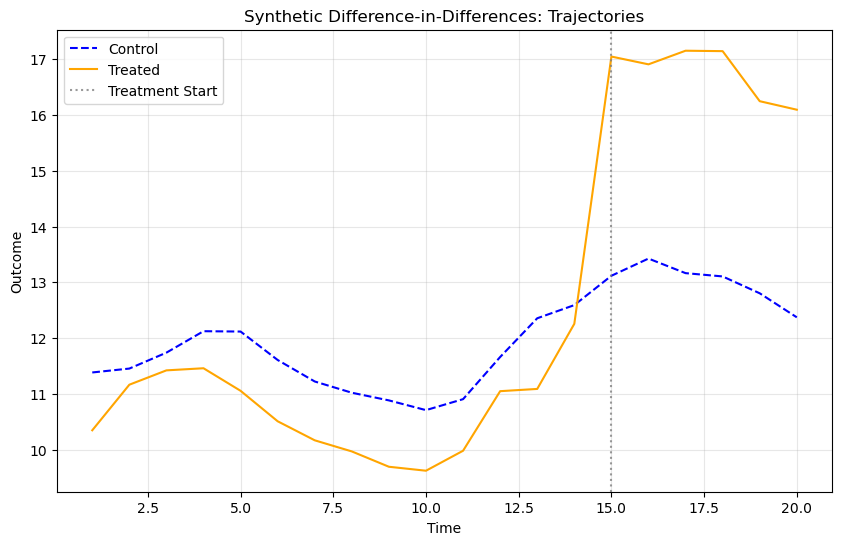

<Axes: title={'center': 'Synthetic Difference-in-Differences: Trajectories'}, xlabel='Time', ylabel='Outcome'>

In [3]:
print(f"estimated ATT = {model1.ATT_diff}")
model1.plot_trajectories()

estimated ATT = 4.862821869442703


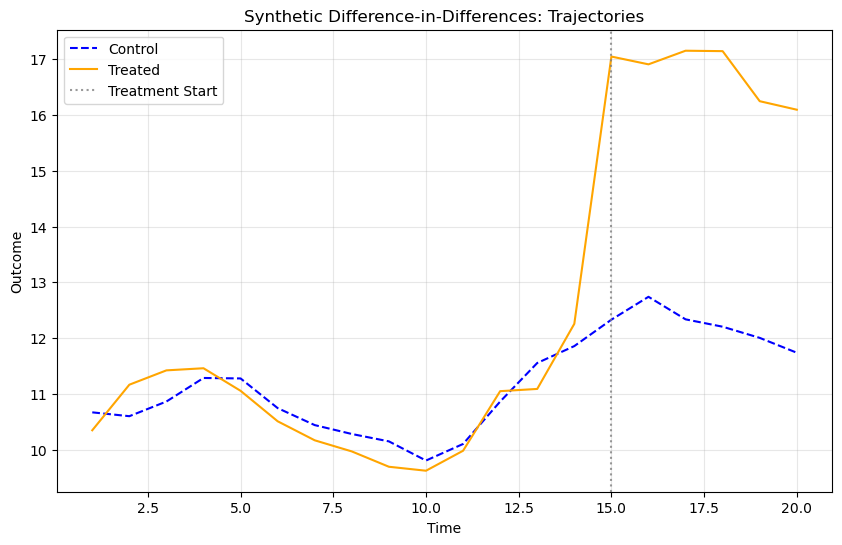

<Axes: title={'center': 'Synthetic Difference-in-Differences: Trajectories'}, xlabel='Time', ylabel='Outcome'>

In [4]:
print(f"estimated ATT = {model2.ATT_diff}")
model2.plot_trajectories()

estimated ATT = 6.732398753219201


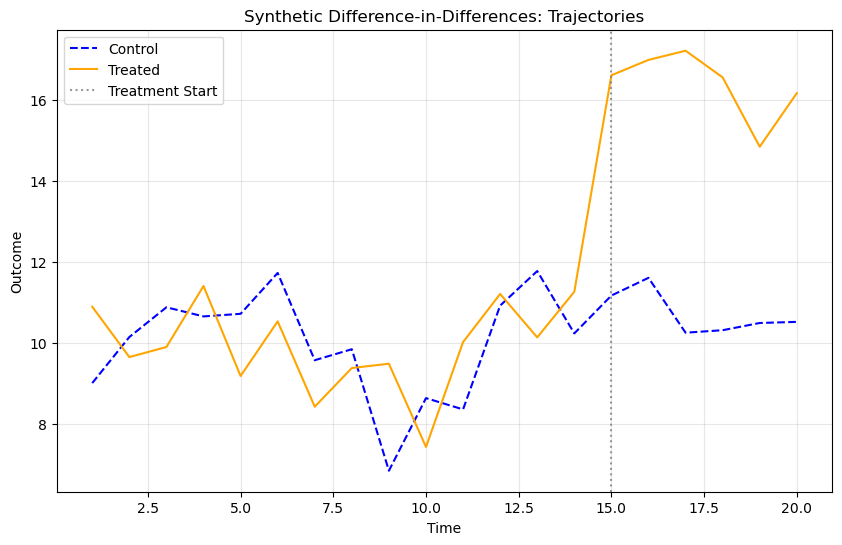

<Axes: title={'center': 'Synthetic Difference-in-Differences: Trajectories'}, xlabel='Time', ylabel='Outcome'>

In [5]:
print(f"estimated ATT = {model3.ATT_diff}")
model3.plot_trajectories()